In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
import pandas as pd

url = "https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Complete_TAVG_daily.txt"

'''
read the data from the url link
ignore the comments starting with '%'
ignore the header in the comments and assign manually
'''
df = pd.read_csv(url, sep=r"\s+", comment="%", header=None)

# assign column headers
column_names = ["Date Number", "Year", "Month", "Day", "Day of Year", "Anomaly"]
df.columns = column_names

df.to_csv("data/raw.csv", index=False)

In [3]:
df = df.drop(columns=['Date Number'])

In [4]:
BASELINE_TEMP = 8.59  # Jan 1951–Dec 1980 land-average temperature in celsius

df['Temperature'] = df['Anomaly'] + BASELINE_TEMP

In [5]:
month_dict = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

df['Month_Name'] = df['Month'].map(month_dict)

## ML 

In [23]:
# -----------------------------------------------------------
# 1. Convert daily data → yearly averages
# -----------------------------------------------------------

# Combine Year–Month–Day into a proper datetime column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Use Date as index so resampling works correctly
df.set_index('Date', inplace=True)

# Resample to yearly means (YE = year-end)
yearly = df['Anomaly'].resample('YE').mean().reset_index()

# Extract year number from datetime column
yearly['Year'] = yearly['Date'].dt.year

# Feature matrix X (year), target vector y (anomaly)
X = yearly[['Year']].values
y = yearly['Anomaly'].values

In [24]:
# -----------------------------------------------------------
# 2. Train–Test Split (train: up to 2012, test: after 2012)
# -----------------------------------------------------------

split_year = 2012  # last 10 years are used for testing

train_mask = yearly['Year'] <= split_year
test_mask  = yearly['Year'] > split_year

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask], y[test_mask]

In [25]:
# -----------------------------------------------------------
# 3. Define Models
# -----------------------------------------------------------

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "SVR": Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01))
    ])
}

In [26]:
# -----------------------------------------------------------
# 4. TRAIN, PREDICT & EVALUATE (Output results as table)
# -----------------------------------------------------------

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)                     # Train
    y_pred = model.predict(X_test)                  # Predict
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
    mae  = mean_absolute_error(y_test, y_pred)      
    r2   = r2_score(y_test, y_pred)                 # Evaluate

    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

# Convert results dictionary → nice DataFrame table
results_table = pd.DataFrame(results).T
print("\nModel Performance on Test Set:\n")
print(results_table)


Model Performance on Test Set:

                       RMSE       MAE         R2
Linear Regression  0.539126  0.521939 -11.652955
Random Forest      0.350576  0.316120  -4.350267
SVR                0.145067  0.120141   0.083892


In [27]:
# -----------------------------------------------------------
# 5. Select Best Model (based on RMSE)
# -----------------------------------------------------------

best_model_name = results_table["RMSE"].idxmin()
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")


Best model: SVR


In [28]:
# -----------------------------------------------------------
# 6. Forecast Temperature Anomaly for 2030
# -----------------------------------------------------------

year_2030 = np.array([[2030]])
forecast_2030_anomaly = best_model.predict(year_2030)[0]

forecast_2030_temp = BASELINE_TEMP + forecast_2030_anomaly

print(f"\nPredicted anomaly for 2030: {forecast_2030_anomaly:.4f} °C")
print(f"Predicted land-average temperature for 2030: {forecast_2030_temp:.4f} °C")


Predicted anomaly for 2030: 1.9696 °C
Predicted land-average temperature for 2030: 10.5596 °C


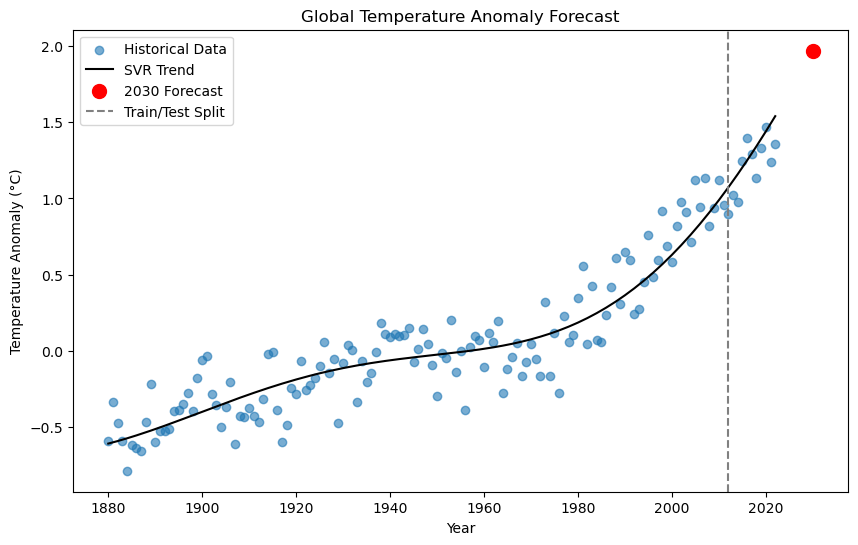

In [30]:
# -----------------------------------------------------------
# 7. PLOT RESULTS
# -----------------------------------------------------------

plt.figure(figsize=(10,6))

# Original yearly data
plt.scatter(yearly['Year'], yearly['Anomaly'], alpha=0.6, label="Historical Data")

# Model trend line
plt.plot(yearly['Year'], best_model.predict(X), color='black', label=f"{best_model_name} Trend")

# Highlight forecast
plt.scatter(2030, forecast_2030_anomaly, color='red', s=100, label="2030 Forecast")

# Train–test split marker
plt.axvline(split_year, color='gray', linestyle='--', label="Train/Test Split")

plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.title("Global Temperature Anomaly Forecast")
plt.legend()
plt.show()